In [1]:
import os
import re

from functools import partial
from collections import Counter

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, names
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.hdpmodel import HdpModel
from gensim.models import CoherenceModel

import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models

dataroot = os.path.join(".")

pyLDAvis_outpath = os.path.join(dataroot, "view", "data.html")
id2word_outpath = os.path.join(dataroot, "models", "id2word.dict")
optimal_model_outpath = os.path.join(dataroot, "models", "lda_model.model")

os.makedirs(os.path.join(dataroot, "view"), exist_ok=True)
os.makedirs(os.path.join(dataroot, "models"), exist_ok=True)

In [2]:
# The csv files containing the data
train_clean_100_path = os.path.join(dataroot, "data", "train-clean-100.csv")
dev_clean_path = os.path.join(dataroot, "data", "dev-clean.csv")
test_clean_path = os.path.join(dataroot, "data", "test-clean.csv")

# Read the csv files
train_df = pd.read_csv(train_clean_100_path, index_col=0)
dev_df = pd.read_csv(dev_clean_path, index_col=0)
test_df = pd.read_csv(test_clean_path, index_col=0)

train_df =  pd.DataFrame({"TEXT": train_df["REAL TEXT"], "BOOK": train_df["BOOK TITLE"], "DURATION": train_df["DURATION"]})
dev_df = pd.DataFrame({"TEXT": dev_df["TEXT"], "BOOK": dev_df["BOOK TITLE"], "DURATION": dev_df["DURATION"]})
test_df = pd.DataFrame({"TEXT": test_df["TEXT"], "BOOK": test_df["BOOK TITLE"], "DURATION": test_df["DURATION"]})

# Merge data in one dataframe
df = pd.concat([train_df, dev_df, test_df])

# Now we can see we have the content of the book, the title and the duration
df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


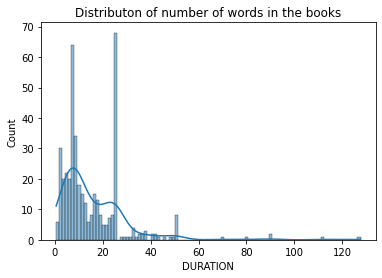

,DURATION
count,422.000000
mean,15.754858
std,14.565170
min,0.540000
25%,7.397500
50%,10.590000
75%,24.840000
max,127.620000


In [3]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [4]:
# First lets remove the books that are too long or too short from our data using the z score
df = df[(np.abs(stats.zscore(df['DURATION'])) < 3)]

df.head()

,TEXT,BOOK,DURATION
0,TILL THEY WOULD FINALLY CIRCLE ROUND AND ROUND...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,AS CINCINNATUS OR CORNELIA NOW TO SUCH A QUIET...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,LOUISE AND BETH HAVING AT LAST FULL KNOWLEDGE ...,Aunt Jane's Nieces,17.11
3,MODE BEARD THE OYSTERS AND SCALD THEM IN THEIR...,The Book of Household Management,5.79
4,SHE SAID SHE WAS NOT ABSOLUTELY CERTAIN OF THE...,The Professor,7.95


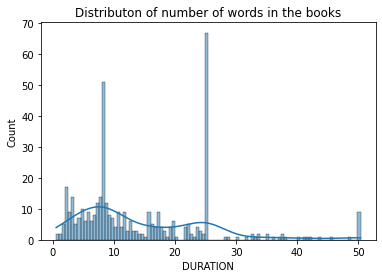

,DURATION
count,416.000000
mean,14.611995
std,10.845341
min,0.540000
25%,7.317500
50%,10.480000
75%,23.920000
max,50.340000


In [5]:
# Lets seee the distribution of the lengths of each sample book
sns.histplot(df, x='DURATION', kde=True, bins=100)
plt.title("Distributon of number of words in the books")
plt.show()
df.describe()

In [6]:
# Now lets convert each string to lower case
df['TEXT'] = df['TEXT'].apply(str.lower)
df.head()

,TEXT,BOOK,DURATION
0,till they would finally circle round and round...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,as cincinnatus or cornelia now to such a quiet...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,louise and beth having at last full knowledge ...,Aunt Jane's Nieces,17.11
3,mode beard the oysters and scald them in their...,The Book of Household Management,5.79
4,she said she was not absolutely certain of the...,The Professor,7.95


In [7]:
# Now lets decontract words that contain "'"

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontract(phrase: str):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['TEXT'] = df['TEXT'].apply(decontract)
df.head()

,TEXT,BOOK,DURATION
0,till they would finally circle round and round...,"The Life of Hon. William F. Cody, Known as Buf...",17.67
1,as cincinnatus or cornelia now to such a quiet...,"Divine Comedy, Longfellow's Translation, Complete",25.10
2,louise and beth having at last full knowledge ...,Aunt Jane's Nieces,17.11
3,mode beard the oysters and scald them in their...,The Book of Household Management,5.79
4,she said she was not absolutely certain of the...,The Professor,7.95


In [8]:
# Now lets tokanize the text string into a list of words
df['TEXT'] = df['TEXT'].apply(word_tokenize)
df.head()

,TEXT,BOOK,DURATION
0,"[till, they, would, finally, circle, round, an...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[as, cincinnatus, or, cornelia, now, to, such,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[louise, and, beth, having, at, last, full, kn...",Aunt Jane's Nieces,17.11
3,"[mode, beard, the, oysters, and, scald, them, ...",The Book of Household Management,5.79
4,"[she, said, she, was, not, absolutely, certain...",The Professor,7.95


In [9]:
# Now lets remove short words from our text
# how short is a short words
_short = 3

def is_not_short(word):
    return len(word) > _short

df['TEXT'] = df['TEXT'].apply(partial(filter, is_not_short)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, they, would, finally, circle, round, ro...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, cornelia, such, quiet, such, bea...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[louise, beth, having, last, full, knowledge, ...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oysters, scald, them, their, liq...",The Book of Household Management,5.79
4,"[said, absolutely, certain, wisdom, step, abou...",The Professor,7.95


In [10]:
# Now lets remove stopwords
_more_stopwords = set([
    # interjections
    "oh", "ah",
    # useless
    "yes", "no",
    # archaic terms: they, you, triplet, to do, you
    "thy", "thou", "thrin", "didst", "thee",
    # other terms that appear often and dont't have any value
    "mister", "missus", "miss",
    # names
    *map(str.lower, names.words())
])
_stopwords = set(stopwords.words('english')) | _more_stopwords

def not_in_stopwords(word):
    return word not in _stopwords

df['TEXT'] = df['TEXT'].apply(partial(filter, not_in_stopwords)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oysters, scald, liquor, well, st...",The Book of Household Management,5.79
4,"[said, absolutely, certain, wisdom, step, take...",The Professor,7.95


In [11]:
# Now lets lemmatize the words to their basic form
# Used to lemmatize words that are either adj, nouns or verbs
# depending on _pos_tags otherwise it does nothing.
_lemmatizer = WordNetLemmatizer()
_pos_tags = ["a", "n", "v"]

def lemmatize(pair):
    word, pos = pair
    pos = pos[0].lower()
    if pos not in _pos_tags:
        return word
    return _lemmatizer.lemmatize(word, pos=pos)

df['TEXT'] = df['TEXT'].apply(pos_tag).apply(partial(map, lemmatize)).apply(list)
df.head()

,TEXT,BOOK,DURATION
0,"[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf...",17.67
1,"[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete",25.10
2,"[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces,17.11
3,"[mode, beard, oyster, scald, liquor, well, str...",The Book of Household Management,5.79
4,"[say, absolutely, certain, wisdom, step, take,...",The Professor,7.95


In [12]:
# Create Dictionary
id2word = Dictionary(df['TEXT'])

# Filter extremes, remove all words that appear in less than 5 documents
# remove all words that appear in more than 50% of the documents
id2word.filter_extremes(no_below=3, no_above=0.25)
id2word.filter_n_most_frequent(5_000)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in df['TEXT']]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]][0][:5]

[('accepted', 1),
 ('advertised', 1),
 ('ambulance', 1),
 ('attended', 1),
 ('avocation', 1)]

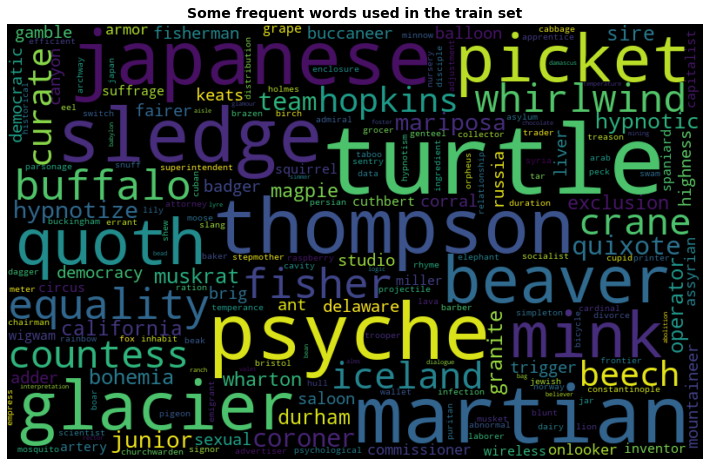

In [13]:
# Now lets visualize a word cloud of our books
all_freq = sum([Counter({id2word[k]: freq for k, freq in cp}) for cp in corpus], start=Counter())

wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(all_freq)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the train set", weight='bold', fontsize=14)
plt.show()

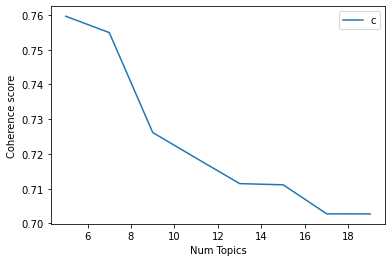

In [14]:
coherence_values = []
model_list = []
x = range(5, 21, 2)

for num_topics in x:
    model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=df['TEXT'], dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [15]:
hdp_model = HdpModel(corpus=corpus, id2word=id2word, K=10, T=15)
coherencemodel = CoherenceModel(model=hdp_model, texts=df['TEXT'], dictionary=id2word, coherence='c_v')
hdp_model_c = coherencemodel.get_coherence()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
best = np.array(coherence_values).argmax()
print(f"The coherence value for the hdp_model is {round(hdp_model_c, 4)}")

lda_model_c = coherence_values[best]
lda_model = model_list[best]

num_topics = x[best] if lda_model_c > hdp_model_c else len(hdp_model.get_topics())

model_name = f"lda" if lda_model_c > hdp_model_c else "hdp"
print(f"Choosing the {model_name} model with {num_topics} topics")
optimal_model = lda_model if lda_model_c > hdp_model_c else hdp_model

# Select the model and print the topics
model_topics = optimal_model.show_topics(num_topics=num_topics, formatted=False)
pprint(optimal_model.print_topics(num_words=10))

Num Topics = 5  has Coherence Value of 0.7596
Num Topics = 7  has Coherence Value of 0.7549
Num Topics = 9  has Coherence Value of 0.7262
Num Topics = 11  has Coherence Value of 0.7188
Num Topics = 13  has Coherence Value of 0.7115
Num Topics = 15  has Coherence Value of 0.7111
Num Topics = 17  has Coherence Value of 0.7028
Num Topics = 19  has Coherence Value of 0.7028
The coherence value for the hdp_model is 0.7771
Choosing the hdp model with 15 topics
[(0,
  '0.002*deceitful + 0.002*sits + 0.002*opium + 0.002*fated + 0.002*ferns + '
  '0.001*cuban + 0.001*winked + 0.001*thigh + 0.001*smiling + '
  '0.001*submissively'),
 (1,
  '0.002*footpath + 0.002*forgetting + 0.002*leaned + 0.002*sill + '
  '0.002*impostor + 0.001*essence + 0.001*antidote + 0.001*contented + '
  '0.001*famously + 0.001*episode'),
 (2,
  '0.002*quail + 0.002*cheque + 0.001*predominant + 0.001*velocity + '
  '0.001*dairy + 0.001*affront + 0.001*promoter + 0.001*lightest + '
  '0.001*expulsion + 0.001*rap'),
 (3,
 

In [17]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(data, pyLDAvis_outpath)
data

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1     -0.018534  0.044799       1        1  8.040592
4      0.039001  0.061180       2        1  7.669006
0     -0.010554  0.009599       3        1  7.542758
11     0.045006 -0.023918       4        1  6.997246
7      0.048897 -0.017957       5        1  6.955338
8     -0.030499  0.001396       6        1  6.946287
2      0.038711 -0.010354       7        1  6.899793
13     0.031250 -0.021687       8        1  6.542179
10    -0.044072 -0.017708       9        1  6.481854
3      0.026309 -0.025963      10        1  6.436623
12    -0.029760 -0.060741      11        1  6.242132
5      0.040107  0.022356      12        1  6.218047
9     -0.050419 -0.056963      13        1  5.732248
14    -0.045925  0.040629      14        1  5.665171
6     -0.039519  0.055330      15        1  5.630727, topic_info=             Term       Freq      Total Category  logprob  loglift
1934    miserably   9.000000   9.000000  Default  30.0000  30.0000
3163       untold  10.000000  10.000000  Default  29.0000  29.0000
620         quoth   9.000000   9.000000  Default  28.0000  28.0000
1615  assiduously   6.000000   6.000000  Default  27.0000  27.0000
250   predominant   8.000000   8.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
1728      enraged   1.559032   6.058036  Topic15  -6.8343   1.5196
3335    steamboat   1.626142   6.649162  Topic15  -6.7921   1.4687
2958  exquisitely   1.678115   7.256050  Topic15  -6.7607   1.4128
3491       vastly   1.618172   6.825610  Topic15  -6.7970   1.4375
761       foreman   1.709694   8.838021  Topic15  -6.7420   1.2342

[729 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3273      4  0.292802    abolition
3273      7  0.292802    abolition
3036      1  0.246055  abstraction
3036      7  0.246055  abstraction
3036     15  0.246055  abstraction
...     ...       ...          ...
553       6  0.344027       zigzag
553      12  0.172014       zigzag
1586      1  0.179110         zone
1586     10  0.179110         zone
1586     11  0.358220         zone

[2511 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 12, 8, 9, 3, 14, 11, 4, 13, 6, 10, 15, 7])

In [18]:
# Get the topic keywords
topic_keywords = [([word for word, prop in optimal_model.show_topic(t)]) for t in range(num_topics)]
topic_keywords_df = pd.DataFrame({'Topic_Keywords': topic_keywords})
topic_keywords_df

,Topic_Keywords
0,"[deceitful, sits, opium, fated, ferns, cuban, ..."
1,"[footpath, forgetting, leaned, sill, impostor,..."
2,"[quail, cheque, predominant, velocity, dairy, ..."
3,"[texas, physicians, cardboard, infantile, comp..."
4,"[escaped, hatchet, distinguished, payment, lit..."
5,"[miserably, freshman, trolley, chaste, whiskey..."
6,"[nutmeg, nip, sinking, blear, beneficent, eter..."
7,"[camel, sanctuary, panther, quarry, aught, cea..."
8,"[scribe, pretext, legislator, tacitly, bulky, ..."
9,"[incomplete, assiduously, unpleasantly, avert,..."


['texas', 'physicians', 'cardboard', 'infantile', 'compelling', 'pearl', 'farmyard', 'logically', 'birmingham', 'thorn', 'lease', 'grade', 'rigidity', 'formed', 'wearied', 'fanaticism', 'dairy', 'definitely', 'tardy', 'violin']
['incomplete', 'assiduously', 'unpleasantly', 'avert', 'repel', 'soothes', 'clouds', 'nettle', 'amass', 'digest', 'proven', 'forenoon', 'stress', 'promontory', 'cigarettes', 'lavish', 'myth', 'reek', 'vastly', 'receptacle']
['pretext', 'forefather', 'fickle', 'pilgrims', 'waiter', 'envoys', 'pervade', 'predominant', 'inherited', 'mouthful', 'naturedly', 'colleague', 'restlessness', 'grandchild', 'civic', 'imbibe', 'penance', 'extinction', 'damask', 'attendance']
['mercury', 'flog', 'cuba', 'consequent', 'robust', 'christen', 'admitted', 'assyrian', 'heavier', 'migration', 'miserably', 'trance', 'northeast', 'divorce', 'canon', 'gloriously', 'gymnasium', 'impediment', 'forenoon', 'forsooth']


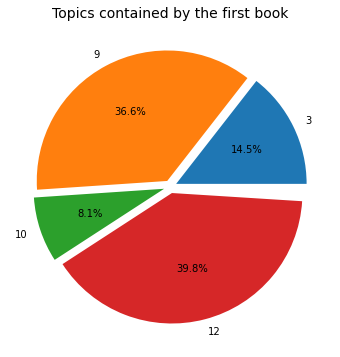

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Text,Book
0,0,12.0,"[0, 0, 0, 0.1446, 0, 0, 0, 0, 0, 0.3661, 0.081...","[till, would, finally, circle, round, round, m...","The Life of Hon. William F. Cody, Known as Buf..."
1,1,11.0,"[0, 0.1478, 0.152, 0.1075, 0, 0, 0.2043, 0, 0,...","[cincinnatus, quiet, beautiful, life, citizen,...","Divine Comedy, Longfellow's Translation, Complete"
2,2,12.0,"[0, 0, 0.108, 0, 0, 0, 0, 0.1836, 0, 0, 0.2535...","[last, full, knowledge, cousin, desire, increa...",Aunt Jane's Nieces
3,3,6.0,"[0.4757, 0, 0, 0, 0, 0, 0.505, 0, 0, 0, 0, 0, ...","[mode, beard, oyster, scald, liquor, well, str...",The Book of Household Management
4,4,9.0,"[0, 0, 0, 0, 0.2521, 0, 0.1507, 0, 0, 0.3934, ...","[say, absolutely, certain, wisdom, step, take,...",The Professor
5,5,1.0,"[0, 0.4335, 0.182, 0, 0, 0, 0, 0, 0, 0, 0.3713...","[never, notice, wealth, pile, discover, accide...",Aunt Jane's Nieces at Millville
6,6,9.0,"[0.1624, 0, 0, 0.3158, 0, 0, 0, 0, 0, 0.5003, ...","[thing, hurtful, doctrine, appear, inexpugnabl...",Autobiography
7,7,10.0,"[0, 0, 0, 0, 0, 0.4008, 0, 0.1725, 0, 0, 0.407...","[purple, pride, soft, cheek, complexion, dwell...",Shakespeare's Sonnets
8,8,1.0,"[0, 0.3163, 0, 0, 0, 0.0952, 0, 0.1866, 0.1201...","[vacation, college, upon, edge, surgery, table...",The Green Flag
9,9,14.0,"[0, 0, 0, 0.1243, 0, 0.2315, 0.2376, 0.1273, 0...","[thump, touch, depth, affection, heart, give, ...",Three John Silence Stories


In [19]:
# Finding the dominant topic in each book
# Init output
dominant_topic_df = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(optimal_model[corpus]):
    topic_num, _ = sorted(row, key=lambda x: (x[1]), reverse=True)[0]
    prop_topics = {t: round(p, 4) for t, p in row}
    prop_topics = [prop_topics.get(t, 0) for t in range(num_topics)]
    dominant_topic_df = dominant_topic_df.append(pd.Series([int(topic_num), prop_topics]), ignore_index=True)
dominant_topic_df.columns = ['Dominant_Topic', 'Perc_Contribution']

dominant_topic_df = pd.concat([dominant_topic_df,  pd.Series(df['TEXT'].to_list()),  pd.Series(df['BOOK'].to_list())], axis=1)

# Format
dominant_topic_df = dominant_topic_df.reset_index()
dominant_topic_df.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text', 'Book']

# Show
example_row = dominant_topic_df.iloc[0]
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(list(range(num_topics)), example_row['Topic_Perc_Contrib']) if v > 0}
for k, v in data.items():
    print(topic_keywords_df['Topic_Keywords'][k])
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=False)
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

dominant_topic_df.head(10)

In [20]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
topic_contrib_df = dominant_topic_df.copy(deep=True)
best_book_topic_df = pd.DataFrame()

for i in range(num_topics):
    bookid = dominant_topic_df['Topic_Perc_Contrib'].apply(lambda p: p[i]).argmax()
    best_book_topic_df = best_book_topic_df.append(pd.Series([i, int(bookid), dominant_topic_df['Text'][bookid], dominant_topic_df['Book'][bookid]]), ignore_index=True)

best_book_topic_df.columns = ['Topic_Num', 'Document_No', 'Text', 'Book']
best_book_topic_df

,Topic_Num,Document_No,Text,Book
0,0.0,390.0,"[care, nothing, brother, sister, stand, round,...",The Book of Stories for the Story-teller
1,1.0,326.0,"[minute, voice, say, time, buzzer, sound, ches...",Planet of the Damned
2,2.0,352.0,"[holy, prelate, fern, related, vision, instruc...",A Popular History of Ireland : from the Earlie...
3,3.0,327.0,"[milner, pass, even, home, niece, command, sti...",A Simple Story
4,4.0,276.0,"[line, bank, river, even, stretch, across, mai...",Travels in Alaska
5,5.0,105.0,"[knit, leave, sixteenth, seamed, make, begin, ...",Exercises in Knitting
6,6.0,77.0,"[bake, little, white, wine, melt, butter, perc...",How to Cook Fish
7,7.0,315.0,"[day, return, ask, wherever, plea, walk, wheth...",Initials Only
8,8.0,127.0,"[begin, fell, tree, timber, ship, make, voyage...",The Golden Fleece and the Heroes Who Lived Bef...
9,9.0,131.0,"[story, would, make, fine, song, say, strong, ...",Viking Tales


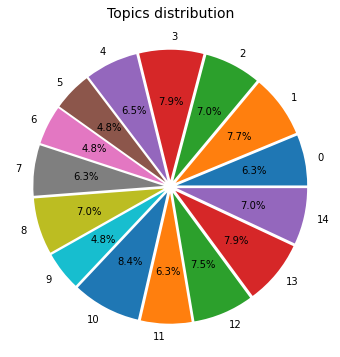

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0,"[deceitful, sits, opium, fated, ferns, cuban, ...",26,0.0625
1.0,1,"[footpath, forgetting, leaned, sill, impostor,...",32,0.0769
2.0,2,"[quail, cheque, predominant, velocity, dairy, ...",29,0.0697
3.0,3,"[texas, physicians, cardboard, infantile, comp...",33,0.0793
4.0,4,"[escaped, hatchet, distinguished, payment, lit...",27,0.0649
5.0,5,"[miserably, freshman, trolley, chaste, whiskey...",20,0.0481
6.0,6,"[nutmeg, nip, sinking, blear, beneficent, eter...",20,0.0481
7.0,7,"[camel, sanctuary, panther, quarry, aught, cea...",26,0.0625
8.0,8,"[scribe, pretext, legislator, tacitly, bulky, ...",29,0.0697
9.0,9,"[incomplete, assiduously, unpleasantly, avert,...",20,0.0481


In [21]:
# Topic distribution across documents

# Number of Documents for Each Topic
topic_counts = dominant_topic_df['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Concatenate Column wise
topics_distribution_df = pd.concat([pd.DataFrame(range(num_topics)), topic_keywords_df, topic_counts, topic_contribution], axis=1)

# Change Column names
topics_distribution_df.columns = ['Topic_Num', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
topics_distribution_df = topics_distribution_df.fillna(0)

# Show
pie, ax = plt.subplots(figsize=[10,6])
data = {k: v for k, v in zip(topics_distribution_df['Topic_Num'], topics_distribution_df['Perc_Documents']) if v > 0}
plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=True)
plt.title("Topics distribution", fontsize=14)
plt.show()

topics_distribution_df

In [24]:
# Run inference on a book example
x = word_tokenize("This is an example of how to run inference but it is a short book".lower())
x = id2word.doc2bow(x)
y_hat = optimal_model[[x]]

Predicted topic for the book "None" are
12 and contains ['mercury', 'flog', 'cuba', 'consequent', 'robust', 'christen', 'admitted', 'assyrian', 'heavier', 'migration', 'miserably', 'trance', 'northeast', 'divorce', 'canon', 'gloriously', 'gymnasium', 'impediment', 'forenoon', 'forsooth'] keywords.
1 and contains ['footpath', 'forgetting', 'leaned', 'sill', 'impostor', 'essence', 'antidote', 'contented', 'famously', 'episode', 'grocery', 'straightforward', 'jungle', 'dissatisfy', 'trophy', 'entrench', 'reasoning', 'eject', 'slang', 'sportive'] keywords.


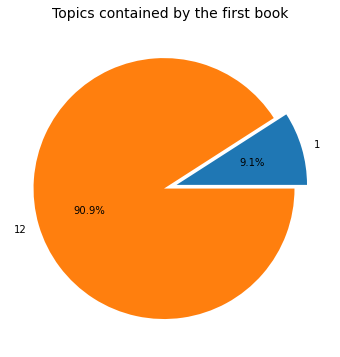

In [25]:
_threshold = 0.05
data = {k: v for k, v in y_hat[0] if v >= _threshold}
topics = sorted(data.items(), key=lambda e: e[1], reverse=True)
print(f"Predicted topic for the book \"{None}\" are")
for k, v in topics:
    print(f"{k} and contains {topic_keywords[k]} keywords.")

pie, ax = plt.subplots(figsize=[10, 6])

plt.pie(x=data.values(), autopct="%.1f%%", explode=[0.05]*len(data.keys()), labels=data.keys(), normalize=True)
plt.title("Topics contained by the first book", fontsize=14)
plt.show()

In [23]:
id2word.save(id2word_outpath)
optimal_model.save(optimal_model_outpath)